In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import rasterio
import pyvista as pv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Cropping2D
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import vtk
from vtk.util import numpy_support as VN
from skimage.metrics import structural_similarity


In [3]:
def read_in_vtk(vtk_filename):
    reader = vtk.vtkStructuredGridReader()
        
    reader.SetFileName( vtk_filename )
    reader.ReadAllVectorsOn()
    reader.ReadAllScalarsOn() 
    reader.Update()
    
    data = reader.GetOutput()
    
    dim = [0,0,0] 
    data.GetDimensions(dim)
    vec = list(dim)
    vec.append(3)
    
    vel_pts = VN.vtk_to_numpy(data.GetPointData().GetArray('wind_vectors'))  ## wind_vectors is NOT seen in the file? But print data showed it, so that's what I used, looks like it worked
    
    vel_3D = vel_pts.reshape(vec,order='F')
    
    U = vel_3D[:,:,:,0]
    V = vel_3D[:,:,:,1]
    W = vel_3D[:,:,:,2]

    return U,V

In [4]:
sample_factor = 4
size = 128

In [5]:
def get_mass_momentum_diff(file_number, wind_direction_folder, wind_direction_file, vegetation_type, plot=True):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"

    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"

    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component
    N_orig = U_mass.shape[0]
    # Downsample for visualization (adjust factor for performance)
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_momentum = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_momentum = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    # print(mean_squared_error(U_sampled_mass, U_sampled_momentum))
    # calculate the difference
    U_diff = U_sampled_momentum - U_sampled_mass
    V_diff = V_sampled_momentum - V_sampled_mass

    min_dimension = np.min([U_diff.shape[0], U_diff.shape[1]])
    U_diff = U_diff[:size, :size]
    V_diff = V_diff[:size, :size]

    X_diff = X_mass[:size, :size]
    Y_diff = Y_mass[:size, :size]

    U_ssim = structural_similarity(U_sampled_momentum, U_sampled_mass, data_range=np.max(U_sampled_momentum) - np.min(U_sampled_momentum))
    V_ssim = structural_similarity(V_sampled_momentum, V_sampled_mass, data_range=np.max(V_sampled_momentum) - np.min(V_sampled_momentum))
    ssim = np.mean([U_ssim, V_ssim])

    elevation = get_elevation_file(file_number)
    # plot

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        im1 = ax1.imshow(velocity_mass, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        #ax1.imshow(elevation, extent=[0, min_dimension, min_dimension, 0])
        ax1.quiver(X_mass, Y_mass, U_sampled_mass, -V_sampled_mass, scale=300, color="black")  # Wind direction arrows

        ax1.set_title("Mass Solver")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")

        #im2 = ax2.imshow(velocity_momentum, cmap="coolwarm", origin="upper")  # Wind speed heatmap
        #ax2.imshow(elevation, extent=[0, min_dimension, min_dimension, 0])
        ax2.quiver(X_momentum, Y_momentum, U_sampled_momentum, -V_sampled_momentum, scale=300, color="black")  # Wind direction arrows

        ax2.set_title("Momentum Solver")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")

        fig.tight_layout()
        plt.show()

        # plot the difference...
        fig = plt.figure(figsize=(10,8))
        
        plt.imshow(elevation, extent=[0, N_orig, N_orig, 0], cmap="coolwarm", origin="upper")
        plt.quiver(X_diff, Y_diff, U_diff, -V_diff, scale=300, color="black")
        plt.title("Difference")
        plt.xlabel('X')
        plt.ylabel("Y")
        plt.show()

    return U_diff, V_diff, ssim
    


In [6]:
def split_elevation(elevation, N, plot=True):
    rows, cols = elevation.shape


    if N >= rows or N >= cols:
        N = min(rows, cols) - 1

    block_size_x = rows // N
    block_size_y = cols // N
    new_elevation = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            block = elevation[i * block_size_x:(i + 1) * block_size_x, j * block_size_y:(j + 1) * block_size_y]
            
            new_elevation[i, j] = np.mean(block)
    
    if plot:
        figure = plt.figure(figsize=(10,12))
        
        ax1 = figure.add_subplot(121)
        ax1.imshow(elevation)
        ax1.set_title("Original Elevation")

        
        ax2 = figure.add_subplot(122)
        ax2.imshow(new_elevation)
        ax2.set_title(f"Approximated Elevation, N = {N}")
        plt.show()

    return new_elevation




In [7]:
def get_elevation_file(file_number):
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"
    with rasterio.open(elevation_tif) as src:
        elevation = src.read(1)  # Reads all bands into a NumPy array
        elevation_npy = np.array(elevation)


    elevation_approx = split_elevation(elevation_npy, size, plot=False)
    return elevation_approx


In [8]:
def get_mass_grid(file_number, wind_direction_file, wind_direction_folder, vegetation_type):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(mass_angle_file) as ang_src_mass, rasterio.open(mass_vel_file) as vel_src_mass:
        angle_mass = ang_src_mass.read(1)  # Wind direction in degrees
        velocity_mass = vel_src_mass.read(1)  # Wind speed in m/s
        transform_mass = ang_src_mass.transform  # Georeferencing
        width_mass, height_mass = ang_src_mass.width, ang_src_mass.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_mass = np.radians(angle_mass)  # Convert degrees to radians
    U_mass = velocity_mass * np.cos(angle_rad_mass)  # X component
    V_mass = velocity_mass * np.sin(angle_rad_mass)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_mass, Y_mass = np.meshgrid(np.arange(0, width_mass, sample_factor), np.arange(0, height_mass, sample_factor))
    U_sampled_mass = U_mass[::sample_factor, ::sample_factor]
    V_sampled_mass = V_mass[::sample_factor, ::sample_factor]

    U_sampled_mass = U_sampled_mass[:size, :size]
    V_sampled_mass = V_sampled_mass[:size, :size]

    return U_sampled_mass, V_sampled_mass

In [9]:
def get_momentum_grid(file_number, wind_direction_file, wind_direction_folder):
    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/grass/{wind_direction_folder}/{wind_direction_file}vel.asc"
    
    with rasterio.open(momentum_angle_file) as ang_src_momentum, rasterio.open(momentum_vel_file) as vel_src_momentum:
        angle_momentum = ang_src_momentum.read(1)  # Wind direction in degrees
        velocity_momentum = vel_src_momentum.read(1)  # Wind speed in m/s
        transform_momentum = ang_src_momentum.transform  # Georeferencing
        width_momentum, height_momentum = ang_src_momentum.width, ang_src_momentum.height  # Raster dimensions

    # Convert wind direction to U, V components for quiver plot
    angle_rad_momentum = np.radians(angle_momentum)  # Convert degrees to radians
    U_mass = velocity_momentum * np.cos(angle_rad_momentum)  # X component
    V_mass = velocity_momentum * np.sin(angle_rad_momentum)  # Y component

    # Downsample for visualization (adjust factor for performance)
    sample_factor = 4  # Change this to control arrow density
    X_momentum, Y_momentum = np.meshgrid(np.arange(0, width_momentum, sample_factor), np.arange(0, height_momentum, sample_factor))
    U_sampled_momentum = U_momentum[::sample_factor, ::sample_factor]
    V_sampled_momentum = V_momentum[::sample_factor, ::sample_factor]

    U_sampled_momentum = U_sampled_momentum[:size, :size]
    V_sampled_momentum = V_sampled_momentum[:size, :size]

    return U_sampled_momentum, V_sampled_momentum

In [10]:
def should_use_num(file_number, wind_direction_file, wind_direction_folder, vegetation_type):

    mass_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    mass_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/mass/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    momentum_angle_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}ang.asc"
    momentum_vel_file = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/momentum/{vegetation_type}/{wind_direction_folder}/{wind_direction_file}vel.asc"
    elevation_tif = f"/Volumes/Expansion/wind_data/{file_number}/dems_folder/dem0/dem0.tif"

    if not os.path.exists(mass_angle_file):
        return False
    
    if not os.path.exists(mass_vel_file):
        return False
    
    if not os.path.exists(momentum_angle_file):
        return False
    
    if not os.path.exists(momentum_vel_file):
        return False
    
    if not os.path.exists(elevation_tif):
        return False
    
    return True

In [11]:
# Lists to store data
X_train_list, y_train_list = [], []

ssims = []
wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']
wind_directions = np.linspace(0,337.5, 16)

for file_num in range(10,200):  
    print("File Number: ", file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):

            wind_direction_folder = wind_direction_folder_names[i]
            wind_direction_file = wind_direction_file_names[i]
            # Load data for this file
            if not should_use_num(file_num, wind_direction_file, wind_direction_folder, vegetation_type):
                continue


            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder, vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)
            # Append to lists
            X_train_list.append(X_sample)
            y_train_list.append(y_sample)

# Convert lists to NumPy arrays
X_train = np.array(X_train_list)  # Shape: (10, size, size, 3)
y_train = np.array(y_train_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

print(X_train.shape)


File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  

In [ ]:
def vegetation_subset_data(vegetation_type):
    if vegetation_type == 'brush'

In [12]:
print("MSE of mass and CFD solver: ")
original_mse = np.mean(np.square(y_train))
print(original_mse)

print("MAE of mass and CFD solver: ")
original_mae = np.mean(np.abs(y_train))
print(original_mae)

print("SSIM of mass and CFD solver: ")
original_ssim = np.mean(ssims)
print(original_ssim)



MSE of mass and CFD solver: 
5.9848027
MAE of mass and CFD solver: 
1.5768907
SSIM of mass and CFD solver: 
0.6040350628929436


In [33]:
# Lists to store data
X_train_annotated_list, y_train_annotated_list = [], []

ssims = []
wind_direction_folder_names = ['0o0deg', '22o5deg', '45o0deg', '67o5deg', '90o0deg', '112o5deg', '135o0deg', '157o5deg', '180o0deg', '202o5deg', '225o0deg', '247o5deg', '270o0deg', '292o5deg', '315o0deg', '337o5deg']
wind_direction_file_names = ['dem0_0_5_100m_', 'dem0_23_5_100m_', 'dem0_45_5_100m_', 'dem0_68_5_100m_', 'dem0_90_5_100m_', 'dem0_113_5_100m_', 'dem0_135_5_100m_', 'dem0_158_5_100m_', 'dem0_180_5_100m_', 'dem0_203_5_100m_', 'dem0_225_5_100m_', 'dem0_248_5_100m_', 'dem0_270_5_100m_', 'dem0_293_5_100m_', 'dem0_315_5_100m_', 'dem0_338_5_100m_']
wind_directions = np.linspace(0,337.5, 16)

for file_num in range(10,200):  
    print("File Number: ", file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):

            wind_direction_folder = wind_direction_folder_names[i]
            wind_direction_file = wind_direction_file_names[i]
            # Load data for this file
            if not should_use_num(file_num, wind_direction_file, wind_direction_folder, vegetation_type):
                continue


            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_folder, wind_direction_file, vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file, wind_direction_folder, vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            vegetation_grid = np.ones_like(U_mass)

            if vegetation_type == 'brush':
                vegetation_grid *= 1
            elif vegetation_type == 'grass':
                vegetation_grid *= 2
            elif vegetation_type == 'trees':
                vegetation_grid *= 3

            wind_angle_grid = np.ones_like(U_mass) * wind_directions[i]
            

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, vegetation_grid, wind_angle_grid, U_mass, V_mass], axis=-1)  # Shape: (size, size, 5)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)
            # Append to lists
            X_train_annotated_list.append(X_sample)
            y_train_annotated_list.append(y_sample)

# Convert lists to NumPy arrays
X_train_annotated = np.array(X_train_annotated_list)  # Shape: (10, size, size, 3)
y_train_annotated = np.array(y_train_annotated_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_train_annotated = tf.convert_to_tensor(X_train_annotated, dtype=tf.float32)
y_train_annotated = tf.convert_to_tensor(y_train_annotated, dtype=tf.float32)

print(X_train_annotated.shape)


File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  

In [35]:
X_test_annotated_list, y_test_annotated_list = [], []
ssims = []
for file_num in range(4,10):  
    print(file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):
            wind_direction_file = wind_direction_file_names[i]
            wind_direction_folder = wind_direction_folder_names[i]

            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue
            # Load data for this file
            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            vegetation_grid = np.ones_like(U_mass)

            if vegetation_type == 'brush':
                vegetation_grid *= 1
            elif vegetation_type == 'grass':
                vegetation_grid *= 2
            elif vegetation_type == 'trees':
                vegetation_grid *= 3

            wind_angle_grid = np.ones_like(U_mass) * wind_directions[i]

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, vegetation_grid, wind_angle_grid, U_mass, V_mass], axis=-1)  # Shape: (size, size, 5)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

            # Append to lists
            X_test_annotated_list.append(X_sample)
            y_test_annotated_list.append(y_sample)

# Convert lists to NumPy arrays
X_test_annotated = np.array(X_test_annotated_list)  # Shape: (10, size, size, 3)
y_test_annotated = np.array(y_test_annotated_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test_annotated = tf.convert_to_tensor(X_test_annotated, dtype=tf.float32)
y_test_annotated = tf.convert_to_tensor(y_test_annotated, dtype=tf.float32)

4
5
6
7
8
9


In [14]:
X_test_list, y_test_list = [], []
ssims = []
for file_num in range(4,10):  
    print(file_num)
    for vegetation_type in ['brush', 'grass', 'trees']:
        for i in range(16):
            wind_direction_file = wind_direction_file_names[i]
            wind_direction_folder = wind_direction_folder_names[i]

            if not should_use_num(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type):
                continue
            # Load data for this file
            U_diff, V_diff, ssim = get_mass_momentum_diff(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type = vegetation_type, plot=False)
            ssims.append(ssim)
            elevation = get_elevation_file(file_num)
            U_mass, V_mass = get_mass_grid(file_num, wind_direction_file=wind_direction_file, wind_direction_folder=wind_direction_folder, vegetation_type=vegetation_type)

            # Convert to NumPy arrays (if they aren't already)
            U_diff, V_diff = np.array(U_diff), np.array(V_diff)
            elevation = np.array(elevation)
            U_mass, V_mass = np.array(U_mass), np.array(V_mass)

            # Ensure correct shape (size, size)
            assert U_diff.shape == (size, size) and V_diff.shape == (size, size)
            assert elevation.shape == (size, size)
            assert U_mass.shape == (size, size) and V_mass.shape == (size, size)

            # Stack inputs into a (size, size, 3) tensor
            X_sample = np.stack([elevation, U_mass, V_mass], axis=-1)  # Shape: (size, size, 3)

            # Stack targets into a (size, size, 2) tensor
            y_sample = np.stack([U_diff, V_diff], axis=-1)  # Shape: (size, size, 2)

            # Append to lists
            X_test_list.append(X_sample)
            y_test_list.append(y_sample)

# Convert lists to NumPy arrays
X_test = np.array(X_test_list)  # Shape: (10, size, size, 3)
y_test = np.array(y_test_list)  # Shape: (10, size, size, 2)


# Convert to TensorFlow tensors
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

4
5
6
7
8
9


In [36]:
# this is defined for all of our models
# input_shape = (size, size, 3)  # Elevation (1 channel) + Mass solver (2 channels)
input_shape = (size, size, 5)
output_shape = (size, size, 2)  # Target difference (2 channels)

In [37]:


# Define CNN Model
def build_small_model():
    inputs = keras.Input(shape=input_shape)

    # Encoder
    
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Bottleneck
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    # Decoder
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    # Output layer
    outputs = layers.Conv2D(2, (1,1), activation="linear", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

# Create model
small_model = build_small_model()
small_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
small_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 32)   │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 128, 128, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 2)    │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,146 (727.13 KB)

 Trainable params: 186,146 (727.13 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Example training
small_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 351ms/step - loss: 435.4712 - mae: 6.5058 - val_loss: 10.4570 - val_mae: 2.4198
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 348ms/step - loss: 4.5759 - mae: 1.4093 - val_loss: 4.6334 - val_mae: 1.4160
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 101s 343ms/step - loss: 3.6806 - mae: 1.2716 - val_loss: 4.6361 - val_mae: 1.4424
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 102s 346ms/step - loss: 3.6574 - mae: 1.2636 - val_loss: 4.4249 - val_mae: 1.4135
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 102s 344ms/step - loss: 3.5427 - mae: 1.2427 - val_loss: 4.6295 - val_mae: 1.3831
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 349ms/step - loss: 3.4699 - mae: 1.2272 - val_loss: 4.3538 - val_mae: 1.4141
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 102s 345ms/step - loss: 3.3511 - mae: 1.2010 - val_loss: 4.2062 - val_mae: 1.3401
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 102s 346ms/step - loss: 3.2485 - mae: 1.1760 - val_loss: 3.9710 - val_mae: 1.3509
Epoch 9/50
295/295 ━━

In [18]:
small_model_predictions = small_model.predict(X_test) 

small_mse = mean_squared_error(y_test.numpy().flatten(), small_model_predictions.flatten())
small_mae = mean_absolute_error(y_test.numpy().flatten(), small_model_predictions.flatten())
small_ssim = structural_similarity(y_test.numpy().flatten(), small_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Small Model Errors")
print("MSE: ", small_mse)
print("MAE: ", small_mae)
print("SSIM: ", small_ssim)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step
Small Model Errors
MSE:  2.936158
MAE:  1.0933777
SSIM:  0.703207545823363


In [38]:
small_model.fit(X_train_annotated, y_train_annotated, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 109s 366ms/step - loss: 1099.8289 - mae: 10.0921 - val_loss: 6.4018 - val_mae: 1.7238
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 353ms/step - loss: 4.6228 - mae: 1.4283 - val_loss: 4.7778 - val_mae: 1.4637
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 104s 352ms/step - loss: 3.7817 - mae: 1.2928 - val_loss: 4.7366 - val_mae: 1.4338
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 107s 362ms/step - loss: 3.6606 - mae: 1.2649 - val_loss: 4.5472 - val_mae: 1.4251
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 108s 364ms/step - loss: 3.5300 - mae: 1.2433 - val_loss: 4.6736 - val_mae: 1.4270
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 105s 354ms/step - loss: 3.5085 - mae: 1.2416 - val_loss: 4.5638 - val_mae: 1.4461
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 103s 350ms/step - loss: 3.2483 - mae: 1.1851 - val_loss: 4.1091 - val_mae: 1.3480
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 106s 360ms/step - loss: 3.2175 - mae: 1.1700 - val_loss: 4.0556 - val_mae: 1.3286
Epoch 9/50
295/295 ━

In [39]:
small_model_predictions = small_model.predict(X_test_annotated) 

small_mse = mean_squared_error(y_test_annotated.numpy().flatten(), small_model_predictions.flatten())
small_mae = mean_absolute_error(y_test_annotated.numpy().flatten(), small_model_predictions.flatten())
small_ssim = structural_similarity(y_test_annotated.numpy().flatten(), small_model_predictions.flatten(), data_range = np.max(y_test_annotated.numpy().flatten()) - np.min(y_test_annotated.numpy().flatten()))
print("Small Model Errors")
print("MSE: ", small_mse)
print("MAE: ", small_mae)
print("SSIM: ", small_ssim)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step
Small Model Errors
MSE:  2.85431
MAE:  1.030957
SSIM:  0.7413663966790321


In [19]:
def build_large_model():
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c4])  # Skip connection
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.Concatenate()([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.Concatenate()([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Output layer (segmentation mask)
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c9)  

    model = Model(inputs, outputs)
    return model

# Example usage:
large_model = build_large_model()
large_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
large_model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_10[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_12[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 512) │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_5[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_14[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_15[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,810 (118.38 MB)

 Trainable params: 31,031,810 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
large_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1202s 4s/step - loss: 1350.8411 - mae: 8.9053 - val_loss: 4.7860 - val_mae: 1.4430
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1189s 4s/step - loss: 3.8906 - mae: 1.3077 - val_loss: 4.9070 - val_mae: 1.4727
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1199s 4s/step - loss: 3.8030 - mae: 1.2966 - val_loss: 4.5816 - val_mae: 1.4327
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1191s 4s/step - loss: 3.6385 - mae: 1.2676 - val_loss: 4.5710 - val_mae: 1.4302
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1193s 4s/step - loss: 3.5612 - mae: 1.2474 - val_loss: 4.4512 - val_mae: 1.4336
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1200s 4s/step - loss: 3.3046 - mae: 1.2005 - val_loss: 4.2673 - val_mae: 1.3976
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1198s 4s/step - loss: 3.2630 - mae: 1.1927 - val_loss: 3.8739 - val_mae: 1.3181
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1208s 4s/step - loss: 2.8863 - mae: 1.1175 - val_loss: 4.2402 - val_mae: 1.3753
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━

In [26]:
large_model_predictions = large_model.predict(X_test) 

large_mse = mean_squared_error(y_test.numpy().flatten(), large_model_predictions.flatten())
large_mae = mean_absolute_error(y_test.numpy().flatten(), large_model_predictions.flatten())
large_ssim = structural_similarity(y_test.numpy().flatten(), large_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Large Model Errors")
print("MSE: ", large_mse)
print("MAE: ", large_mae)
print("SSIM: ", large_ssim)

9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Large Model Errors
MSE:  1.8191209
MAE:  0.87644047
SSIM:  0.7689844439322189


In [21]:
def build_medium_model():
    inputs = layers.Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    # Bottleneck
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    # Decoder (Upsampling)
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.Concatenate()([u6, c2])  # Skip connection
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.Concatenate()([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)


    # Output layer (segmentation mask)
    outputs = layers.Conv2D(2, (1, 1), activation="linear")(c7)  

    model = Model(inputs, outputs)
    return model

# Example usage:
medium_model = build_medium_model()
medium_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
medium_model.summary()



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_25[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_27[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_29[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │    131,200 │ conv2d_30[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │    295,040 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_31[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 128, 128,  │     32,832 │ conv2d_32[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 128,  │     73,792 │ concatenate_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_33[0][0] 

 Total params: 1,862,914 (7.11 MB)

 Trainable params: 1,862,914 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
medium_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)


Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - loss: 572.1513 - mae: 6.5186 - val_loss: 6.0849 - val_mae: 1.6657
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1365s 5s/step - loss: 4.2560 - mae: 1.3651 - val_loss: 4.8870 - val_mae: 1.4958
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1104s 4s/step - loss: 3.8762 - mae: 1.3073 - val_loss: 4.7650 - val_mae: 1.4768
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1378s 5s/step - loss: 3.6935 - mae: 1.2797 - val_loss: 4.3723 - val_mae: 1.3924
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1402s 5s/step - loss: 3.2200 - mae: 1.1770 - val_loss: 4.0390 - val_mae: 1.3596
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - loss: 3.0826 - mae: 1.1452 - val_loss: 3.6154 - val_mae: 1.2634
Epoch 7/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 938s 3s/step - loss: 2.8433 - mae: 1.0942 - val_loss: 3.5608 - val_mae: 1.2460
Epoch 8/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 968s 3s/step - loss: 2.8437 - mae: 1.1009 - val_loss: 3.4658 - val_mae: 1.2632
Epoch 9/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
medium_model_predictions = medium_model.predict(X_test) 

medium_mse = mean_squared_error(y_test.numpy().flatten(), medium_model_predictions.flatten())
medium_mae = mean_absolute_error(y_test.numpy().flatten(), medium_model_predictions.flatten())
medium_ssim = structural_similarity(y_test.numpy().flatten(), medium_model_predictions.flatten(), data_range = np.max(y_test.numpy().flatten()) - np.min(y_test.numpy().flatten()))
print("Medium Model Errors")
print("MSE: ", medium_mse)
print("MAE: ", medium_mae)
print("SSIM: ", medium_ssim)

9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
Medium Model Errors
MSE:  2.1743429
MAE:  0.9469242
SSIM:  0.752265410872627


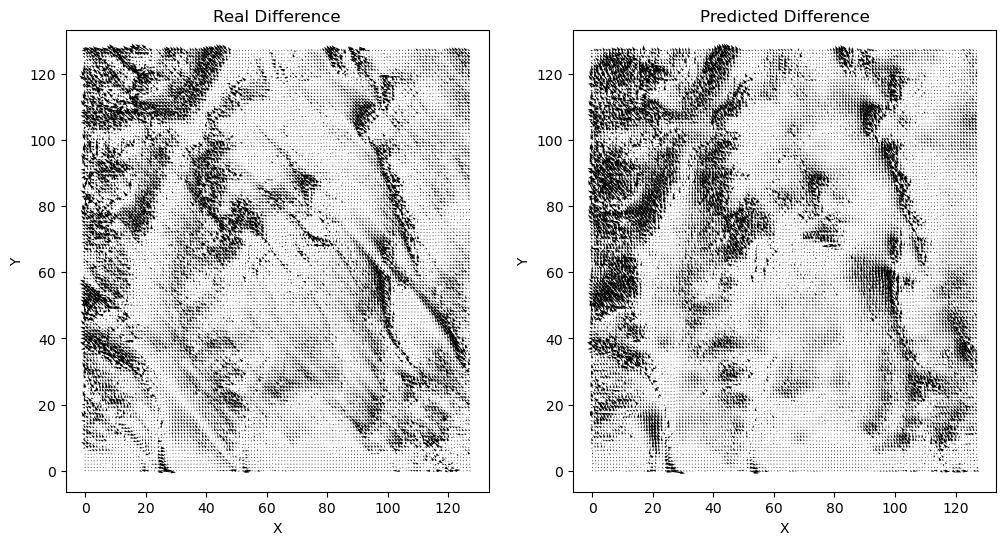

In [44]:
i = 50

U_diff_test = y_test[i, :, :, 0]
V_diff_test = y_test[i, :, :, 1]

U_diff_pred = medium_model_predictions[i, :, :, 0]
V_diff_pred = medium_model_predictions[i, :, :, 1]


fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.quiver(U_diff_test, -V_diff_test, scale=300, color="black")
ax1.set_title("Real Difference")
ax1.set_xlabel('X')
ax1.set_ylabel("Y")

ax2.quiver(U_diff_pred, -V_diff_pred, scale=300, color="black")
ax2.set_title("Predicted Difference")
ax2.set_xlabel('X')
ax2.set_ylabel("Y")

plt.show()


